In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import tensorflow as tf


from scipy import signal
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Input, Flatten, Embedding, Conv1D, Conv2D, Dropout, MaxPooling2D, Bidirectional
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import label_binarize



Mounted at /content/drive/


In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
assert tf.executing_eagerly()

import tensorflow_hub as hub
import pickle
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = "/content/drive/MyDrive/Data/"
sessions = ['Session1','Session2','Session3','Session4','Session5']

with open(data_path +'/data_collected2.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

# read output label
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
Y = label_binarize(y=Y, classes=emotions_used)
Y




array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [ ]:
# wav_as_float_or_int16 = data2[0]['signal']
# module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3')
# emb_dict = module(samples=wav_as_float_or_int16, sample_rate=16000)
# emb_layer19 = emb_dict['layer19']
# print(emb_layer19.shape)
# trill44.append(emb_layer19)

In [ ]:
trill_features = []
for ses_mod in data2:
  wav_as_float_or_int16 = ses_mod['signal']
  module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3')
  emb = module(samples=wav_as_float_or_int16, sample_rate=16000)['embedding']
  trill_features.append(np.array(emb))


trill_features = np.array(trill_features)
trill_features.shape
np.save('trill_features.npy', trill_features)

<ipython-input-57-1c22756a697b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trill_features = np.array(trill_features)


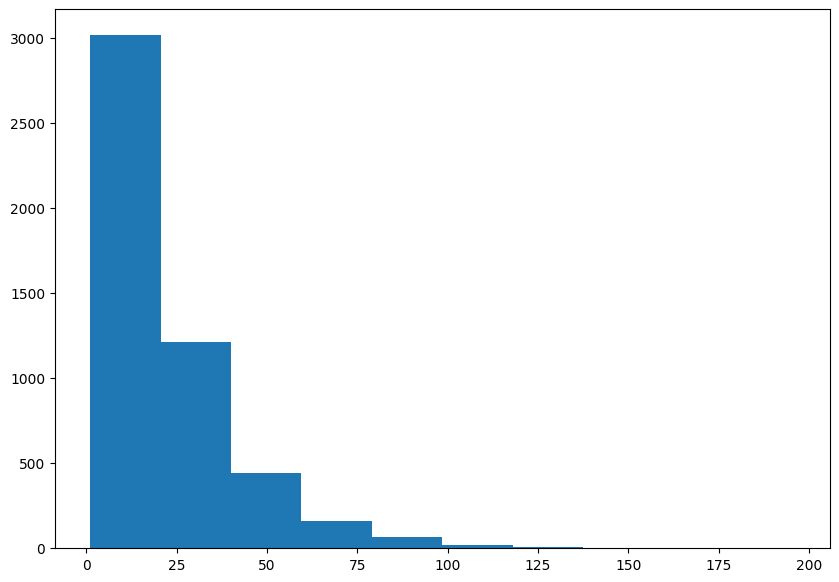

In [ ]:
X1 = np.load('/content/drive/MyDrive/Data/trill_features.npy',allow_pickle=True)
feature_graph=[]
for i in range(0,len(X1)):
  feature_graph.append(X1[i].shape[0])

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize =(10,7))
ax.hist(feature_graph, bins = 10)
plt.show()




In [ ]:
# from scipy.io.wavfile import read
# a = read("/content/460598__mirwanda__ivr-silence-16-bit-mono-16-khz.wav")

# sil= np.array(a[1],dtype='int16')


# silence_wavfile =[]

# module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3')
# emb = module(samples=sil, sample_rate=16000)['embedding']
# print(emb.shape)
# silence_wavfile.append(np.array(emb))



249792

In [ ]:
silence_duration = 1
sample_rate = 16000

# Calculate the number of samples needed for the specified duration
num_samples = int(silence_duration * sample_rate)

# Generate an array of zeros representing silence
silence_array = np.zeros(num_samples, dtype=np.int16)
print(silence_array)

silence_cg =[]

module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3')
emb = module(samples=silence_array, sample_rate=16000)['embedding']
print(emb.shape)
silence_cg.append(np.array(emb))
silence_trill_values = silence_cg[0][0]
silence_trill_values


[0 0 0 ... 0 0 0]
(1, 2048)


array([-0.23181325, -0.01003219,  0.00422064, ..., -0.08759604,
        0.03211117, -0.03920655], dtype=float32)

In [ ]:
trill_features_normalized=[]

thres=20
for ses_mod in data2:
  wav_as_float_or_int16 = ses_mod['signal']
  module = hub.load('https://tfhub.dev/google/nonsemantic-speech-benchmark/trill-distilled/3')
  emb = module(samples=wav_as_float_or_int16, sample_rate=16000)['embedding']
  if(emb.shape[0]<thres):
    while(emb.shape[0]<thres):
      emb=np.vstack((emb,silence_trill_values))
  elif(emb.shape[0]>thres):
      emb=emb[:thres]
  trill_features_normalized.append(np.array(emb))
np.save('trill_features_normalized_thres20.npy',trill_features_normalized)

In [ ]:
X = np.load('trill_features_normalized_thres20.npy')

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

X.shape

(4936, 20, 2048)

MODEL 1

In [ ]:
def speech_model1():
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(20,2048)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model1 = speech_model1()
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 512)           5244928   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
 activation_1 (Activation)   (None, 4)                 0         
                                                                 
Total params: 6,166,020
Trainable params: 6,166,020
Non-

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model1.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch')
hist1 = model1.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, shuffle = False,callbacks=[checkpoint])

Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 1.3800 - accuracy: 0.3248
Epoch 1: loss improved from inf to 1.38001, saving model to best_model1.hdf5
104/104 [==============================] - 98s 896ms/step - loss: 1.3800 - accuracy: 0.3248
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.3765
Epoch 2: loss improved from 1.38001 to 1.32642, saving model to best_model1.hdf5
104/104 [==============================] - 91s 875ms/step - loss: 1.3264 - accuracy: 0.3765
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 1.2037 - accuracy: 0.4348
Epoch 3: loss improved from 1.32642 to 1.20367, saving model to best_model1.hdf5
104/104 [==============================] - 91s 877ms/step - loss: 1.2037 - accuracy: 0.4348
Epoch 4/50
104/104 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.4602
Epoch 4: loss improved from 1.20367 to 1.15224, saving model to best_model1.hdf5
104/104 [===========

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, classification_report

Y_pred=model1.predict(X_test)
Y_pred=np.argmax(Y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)
print('\nConfusion Matrix\n')
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

acc1 = hist1.history['accuracy']
print('\nTraining Accuracy\n')
print('Mean Training Accuracy',np.mean(acc1))
print('Max Training Accuracy',max(acc1))

print('\nClassification Report\n')
print(classification_report(Y_test, Y_pred, target_names= emotions_used))

print('Class Wise Accuracy\n')
acc=0
for idx in range(0,4):
  sum=0
  for j in range(0,4):
    sum= sum + cm[idx][j]
  acc = cm[idx][idx] / sum
  print(emotions_used[idx]," : ",acc)

51/51 [==============================] - 22s 431ms/step

Confusion Matrix

[[127 142  90  15]
 [ 18 222  89  15]
 [ 14 101 321 115]
 [  4  18 106 232]]

Training Accuracy

Mean Training Accuracy 0.6830541229248047
Max Training Accuracy 0.9110976457595825

Classification Report

              precision    recall  f1-score   support

         ang       0.78      0.34      0.47       374
         exc       0.46      0.65      0.54       344
         neu       0.53      0.58      0.55       551
         sad       0.62      0.64      0.63       360

    accuracy                           0.55      1629
   macro avg       0.60      0.55      0.55      1629
weighted avg       0.59      0.55      0.55      1629

Class Wise Accuracy

ang  :  0.339572192513369
exc  :  0.6453488372093024
neu  :  0.5825771324863884
sad  :  0.6444444444444445


MODEL 2

In [ ]:
from keras import backend as K
from keras.layers import LSTM,RNN
from keras import regularizers, constraints, initializers, activations
from tensorflow.keras.layers import InputSpec,Layer
from tensorflow.keras.layers import LSTMCell

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x




In [ ]:
def global_attention_model(optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(LSTM(256, return_sequences=True),input_shape=(20,2048)))
    model.add(GlobalSelfAttention(num_heads=4,key_dim=128))
    model.add(FeedForward(512,2048))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model2 = global_attention_model()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 512)          4720640   
 l)                                                              
                                                                 
 global_self_attention (Glob  (None, 20, 512)          1051648   
 alSelfAttention)                                                
                                                                 
 feed_forward (FeedForward)  (None, 20, 512)           2100736   
                                                                 
 flatten (Flatten)           (None, 10240)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                655424    
                                                                 
 batch_normalization (BatchN  (None, 64)              

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model2.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto',  save_freq='epoch')
hist2 = model2.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, shuffle = False,
                 callbacks=[checkpoint])

Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 1.2158 - accuracy: 0.4466
Epoch 1: loss improved from inf to 1.21579, saving model to best_model2.hdf5
104/104 [==============================] - 105s 901ms/step - loss: 1.2158 - accuracy: 0.4466
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 1.0151 - accuracy: 0.5461
Epoch 2: loss improved from 1.21579 to 1.01513, saving model to best_model2.hdf5
104/104 [==============================] - 92s 884ms/step - loss: 1.0151 - accuracy: 0.5461
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 0.9987 - accuracy: 0.5479
Epoch 3: loss improved from 1.01513 to 0.99871, saving model to best_model2.hdf5
104/104 [==============================] - 93s 894ms/step - loss: 0.9987 - accuracy: 0.5479
Epoch 4/50
104/104 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.5894
Epoch 4: loss improved from 0.99871 to 0.94245, saving model to best_model2.hdf5
104/104 [==========

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, classification_report

Y_pred=model2.predict(X_test)
Y_pred=np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix\n')

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
print('\nTraining Accuracy\n',)
acc2 = hist2.history['accuracy']
print('Mean Training Accuracy',np.mean(acc2))
print('Max Training Accuracy',max(acc2))



print('\nClassification Report\n')
print(classification_report(Y_test, Y_pred, target_names= emotions_used))


# Calculate the accuracy for each one of our classes
print('Class Wise Accuracy\n')
acc=0
for idx in range(0,4):
  sum=0
  for j in range(0,4):
    sum= sum + cm[idx][j]
  acc = cm[idx][idx] / sum
  print(emotions_used[idx]," : ",acc)

51/51 [==============================] - 20s 387ms/step

Confusion Matrix

[[233  62  53  26]
 [ 81 162  84  17]
 [ 72  83 295 101]
 [ 21   8  91 240]]

Training Accuracy

Mean Training Accuracy 0.8905352252721787
Max Training Accuracy 1.0

Classification Report

              precision    recall  f1-score   support

         ang       0.57      0.62      0.60       374
         exc       0.51      0.47      0.49       344
         neu       0.56      0.54      0.55       551
         sad       0.62      0.67      0.65       360

    accuracy                           0.57      1629
   macro avg       0.57      0.57      0.57      1629
weighted avg       0.57      0.57      0.57      1629

Class Wise Accuracy

ang  :  0.6229946524064172
exc  :  0.47093023255813954
neu  :  0.5353901996370236
sad  :  0.6666666666666666


MODEL 3

In [ ]:
from keras import backend as K
from keras.layers import LSTM,RNN
from keras import regularizers, constraints, initializers, activations
from tensorflow.keras.layers import InputSpec,Layer
from tensorflow.keras.layers import LSTMCell

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


In [ ]:
from keras.layers import Input, Dense, SimpleRNN, LSTM, Bidirectional
def LSTMattention(hidden_units, dense_units, input_shape, activation):
    mainmodel=Sequential()
    x=Input(shape=input_shape)
    BiLSTM_layer = Bidirectional(LSTM(hidden_units, return_sequences=True))(x)
    attention_layer = attention()(BiLSTM_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    mainmodel.add(model)
    mainmodel.add(Dense(512, activation='relu'))
    mainmodel.add(Dense(4, activation='softmax'))

    mainmodel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return mainmodel

model3 = LSTMattention(hidden_units=128, dense_units=4,input_shape=(20,2048), activation='tanh')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4)                 2230552   
                                                                 
 dense_7 (Dense)             (None, 512)               2560      
                                                                 
 dense_8 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2,235,164
Trainable params: 2,235,164
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model3.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto',  save_freq='epoch')
hist3 = model3.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, shuffle = False,
                 callbacks=[checkpoint])

Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 1.2685 - accuracy: 0.3973
Epoch 1: loss improved from inf to 1.26849, saving model to best_model3.hdf5
104/104 [==============================] - 34s 274ms/step - loss: 1.2685 - accuracy: 0.3973
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 1.1330 - accuracy: 0.4805
Epoch 2: loss improved from 1.26849 to 1.13302, saving model to best_model3.hdf5
104/104 [==============================] - 28s 271ms/step - loss: 1.1330 - accuracy: 0.4805
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 1.0904 - accuracy: 0.4977
Epoch 3: loss improved from 1.13302 to 1.09038, saving model to best_model3.hdf5
104/104 [==============================] - 28s 271ms/step - loss: 1.0904 - accuracy: 0.4977
Epoch 4/50
104/104 [==============================] - ETA: 0s - loss: 1.0633 - accuracy: 0.5116
Epoch 4: loss improved from 1.09038 to 1.06332, saving model to best_model3.hdf5
104/104 [===========

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, classification_report

Y_pred=model3.predict(X_test)
Y_pred=np.argmax(Y_pred, axis=1)

cm = confusion_matrix(Y_test, Y_pred)
print('\nConfusion Matrix\n')
print(cm)

acc3 = hist3.history['accuracy']
print('\nTraining Accuracy\n',)
print('Mean Training Accuracy',np.mean(acc3))
print('Max Training Accuracy',max(acc3))

print('\nClassification Report\n')
print(classification_report(Y_test, Y_pred, target_names= emotions_used))

# Calculate the accuracy for each one of our classes

print('Class Wise Accuracy\n')
acc=0
for idx in range(0,4):
  sum=0
  for j in range(0,4):
    sum= sum + cm[idx][j]
  acc = cm[idx][idx] / sum
  print(emotions_used[idx]," : ",acc)

51/51 [==============================] - 9s 171ms/step

Confusion Matrix

[[219  81  47  27]
 [ 55 203  66  20]
 [ 54  78 310 109]
 [ 13  10  59 278]]

Training Accuracy

Mean Training Accuracy 0.6872028976678848
Max Training Accuracy 0.8303598165512085

Classification Report

              precision    recall  f1-score   support

         ang       0.64      0.59      0.61       374
         exc       0.55      0.59      0.57       344
         neu       0.64      0.56      0.60       551
         sad       0.64      0.77      0.70       360

    accuracy                           0.62      1629
   macro avg       0.62      0.63      0.62      1629
weighted avg       0.62      0.62      0.62      1629

Class Wise Accuracy

ang  :  0.5855614973262032
exc  :  0.5901162790697675
neu  :  0.5626134301270418
sad  :  0.7722222222222223
